<a href="https://colab.research.google.com/gist/KhawajaMuddassar/da5ce9d2065fa1a4f3d74a6eddcb83d2/facegeneration_cgan_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conditional Generative Adversarial Network (cGAN):**
The Conditional Generative Adversarial Network (cGAN) is a model used in deep learning. It enables more precise generation and discrimination of images to train machines and allow them to learn on their own. and it has multiple uses in the field of machine learning.

1. **Image-to-image translation:**
cGANs, in particular, allow images to evolve by considering additional information, such as labels. cGANs have enabled the development of the Pix2Pix method, some applications of which include object reconstruction from edges, photo synthesis from label maps, and image colorization.

2. **Creating images from text:**
it's possible to create high-quality photos based on text. Using text and the richness of its vocabulary enables the generation of much more precise synthetic images.
3. **Video generation:**
In video, cGANs can also predict future frames of a video based on a selection of previous images.
4. **Face generation:**
cGANs can be used to generate images of faces with specific attributes, such as hair or eye color.

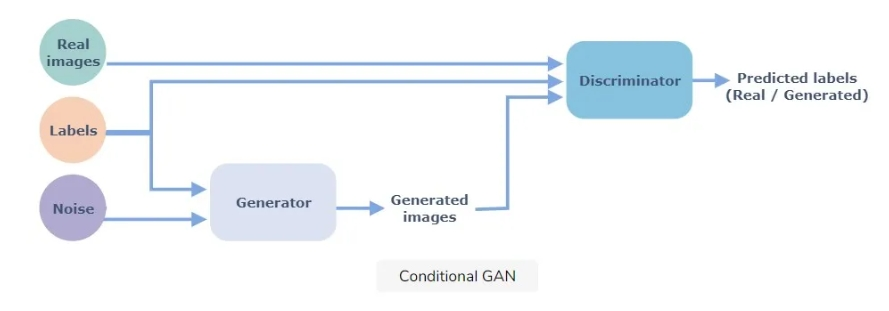

In [ ]:
!pip install -q --upgrade torch_snippets gdown torchsummary
import os, sys, torch, torchvision, numpy as np, torch.nn as nn, cv2, gdown, zipfile, time
from torch_snippets.torch_loader import Dataset, DataLoader, Report
from torch_snippets.loader import  read,Tqdm, show
from torch_snippets.paths import Glob
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image
from random import random
from torchsummary import summary
import torchvision.utils as vutils
from matplotlib import pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.9 MB/s eta 0:00:00


In [ ]:
class Preprocessor:
    def __init__(self, FileID='1Mf-JW9YFzGDxcCtmDebFBVdMQIqqu7gg'):
        self.FileID = FileID
        self.url = f'https://drive.google.com/uc?id={self.FileID}'
        self.TargetFolder = '/content/'
        self.ZipFile = 'Gender_Faces.zip'
    def GetData(self):
        gdown.download(self.url, self.ZipFile, quiet=False)
        if not os.path.exists(self.TargetFolder):
            os.makedirs(self.TargetFolder)
    def Unzip(self):
        with zipfile.ZipFile(self.ZipFile, 'r') as zipref:
            zipref.extractall(self.TargetFolder)
            print(f'\nDataset downloaded and extracted to {self.TargetFolder} successfully!')
    def RemoveZip(self):
        os.remove(self.ZipFile)
        print(f'\nCompressed file {self.ZipFile} removed!')
    def Run(self):
        self.GetData()
        self.Unzip()
        self.RemoveZip()

class FaceCropper:
    def __init__(self):
        # Load the pre-trained Haar Cascade Classifier for face detection
        self.FaceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.Females = Glob('/content/Gender_Faces/Female_Faces/*.jpg')
        self.Males = Glob('/content/Gender_Faces/Male_Faces/*.jpg')
    def ApplyCrop(self, folder):
        print("\nBuilding Cropped Datasets ....\n")
        all_images = Glob(folder + '/*.jpg')
        # Loop over the images
        for idx in Tqdm(range(len(all_images))):
            image = cv2.imread(all_images[idx])
            if image is None:
                print(f"Error loading image: {all_images[idx]}")
                continue
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Detect faces in the image
            faces = self.FaceCascade.detectMultiScale(gray_image, scaleFactor=1.3, minNeighbors=5)
            # Loop through the faces found in the image
            for (x, y, w, h) in faces:
                new_image = image[y:y+h, x:x+w]
                resized_image = cv2.resize(new_image, (64, 64))
                cropped_folder = folder + '_Cropped'
                os.makedirs(cropped_folder, exist_ok=True)
                cv2.imwrite(f'{cropped_folder}/{str(idx)}.png', resized_image,[int(cv2.IMWRITE_JPEG_QUALITY), 100])
        print("\nCompleted! ....\n")

# Dataset class
class Faces(Dataset):
    def __init__(self, folders):
        super().__init__()
        self.Female = folders[0]
        self.Male = folders[1]
        self.Images = sorted(Glob(self.Female)) + sorted(Glob(self.Male))
        self.transform = transforms.Compose([
            transforms.ToTensor(),])
    def __len__(self):
        return len(self.Images)
    def __getitem__(self, idx):
        Image_Path = str(self.Images[idx])
        ImageRead = Image.open(Image_Path)
        img_tensor = self.transform(ImageRead)

        Gender = np.where('Female' in Image_Path, 1, 0)
        return img_tensor, torch.tensor(Gender).long()
    # Function to visualize multiple images after transformation
    def show_resized_images(self, start_idx, num_images=6):
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(3, 3))
        axes = axes.flatten()
        print('\nCropped Images:')
        # Loop through the number of images and display them
        for i in range(num_images):
            idx = start_idx + i
            img_tensor, label = self[idx]
            img = img_tensor.permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"{img.shape}")
        plt.tight_layout()
        plt.show()

# Generator and Discriminator Networks
class Models:
    class Discriminator(nn.Module):
        def __init__(self,emb_size=32):
            super(Models.Discriminator,self).__init__()
            self.emb_size = 32 # Number of Embeddings to convert input class label
            self.label_emb = nn.Embedding(2, self.emb_size) # sorted here
            self.model = nn.Sequential(
                # Initial Convolutions (downsampling)
                nn.Conv2d(3,64,4,2,1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                # Downsample to 128 features
                nn.Conv2d(64, 64*2, 4,2,1,bias=False),
                nn.BatchNorm2d(64*2),
                nn.LeakyReLU(0.2,inplace=True),

                # Downsample to 256 features
                nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64*4),
                nn.LeakyReLU(0.2, inplace=True),

                # Downsample to 512 features
                nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64*8),
                nn.LeakyReLU(0.2, inplace=True),

                # Downsample to 64 features
                nn.Conv2d(64*8, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                # Flattened into a 1D tensor
                nn.Flatten() )
            # Fully Connected Layers
            self.model2 = nn.Sequential(
                nn.Linear(288,100),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(100,1),
                nn.Sigmoid() )
            self.apply(self.Weights)
        def forward(self,input,labels):
            x = self.model(input)
            y = self.label_emb(labels)
            input = torch.cat([x,y],1)
            out_put = self.model2(input)
            return out_put
        def Weights(self,m):
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)
    class Generator(nn.Module):
        def __init__(self, emb_size=32):
            super(Models.Generator,self).__init__()
            self.emb_size = emb_size
            self.label_emb = nn.Embedding(2,self.emb_size)
            self.model = nn.Sequential(
                # Latent vector (100) + label embedding, 64*8 feature maps
                nn.ConvTranspose2d(100+self.emb_size,64*8,4,1,0,bias=False),
                nn.BatchNorm2d(64*8),
                nn.ReLU(True),

                # Upsample to 256 feature maps
                nn.ConvTranspose2d(64*8, 64*4, 4,2,1,bias=False),
                nn.BatchNorm2d(64*4),
                nn.ReLU(True),

                # Upsample to 128 feature maps
                nn.ConvTranspose2d(64*4, 64*2, 4,2,1,bias=False),
                nn.BatchNorm2d(64*2),
                nn.ReLU(True),

                # Upsample to 64 feature maps
                nn.ConvTranspose2d(64*2, 64, 4,2,1,bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),

                # Final layer: Output a 3-channel image (RGB)
                nn.ConvTranspose2d(64, 3, 4,2,1,bias=False),
                nn.Tanh() )
            self.apply(self.Weights)
        def forward(self,input_noise,labels):
            label_embeddings = self.label_emb(labels).view(len(labels),self.emb_size, 1, 1)
            input = torch.cat([input_noise,label_embeddings],1)
            return self.model(input)
        def Weights(self,m):
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)

# Training Models over increasing number of EPOCHS
class TrainModels:
    def __init__(self, dataloader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.dataloader = dataloader
        # Model Objects
        self.disc_model = Models.Discriminator().to(self.device)
        self.gen_model = Models.Generator().to(self.device)
        # Optimizers
        self.disc_optimizer = optim.Adam(self.disc_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.gen_optimizer = optim.Adam(self.gen_model.parameters(), lr=0.0001, betas=(0.5, 0.9999))
        # Loss
        self.Loss = nn.BCELoss()
        self.fixed_noise = torch.randn(64, 100, 1, 1, device=self.device)
        self.fixed_fake_labels = torch.LongTensor([0] * (len(self.fixed_noise) // 2) + [1] * (len(self.fixed_noise) // 2)).to(self.device)
        self.epochs = 35
        self.image_list = []  # Store images generated by the generator

    def Train_Discriminator(self, real_data, real_labels, fake_data, fake_labels):
        self.disc_optimizer.zero_grad()
        # Real
        real_pred = self.disc_model(real_data, real_labels)
        real_error = self.Loss(real_pred, torch.ones(len(real_data), 1).to(self.device))
        real_error.backward()
        # Fake
        fake_pred = self.disc_model(fake_data, fake_labels)
        fake_error = self.Loss(fake_pred, torch.zeros(len(fake_data), 1).to(self.device))
        fake_error.backward()
        self.disc_optimizer.step()
        return real_error + fake_error

    def Train_Generator(self, fake_data, fake_labels):
        self.gen_optimizer.zero_grad()
        pred = self.disc_model(fake_data, fake_labels)
        error = self.Loss(pred, torch.ones(len(fake_data), 1).to(self.device))
        error.backward()
        self.gen_optimizer.step()
        return error

    def Trainer(self):
        log = Report(self.epochs)
        for epoch in range(self.epochs):
            num = len(self.dataloader)
            for idx, (images, labels) in enumerate(self.dataloader):
                real_data, real_labels = images.to(self.device), labels.to(self.device)
                fake_labels = torch.LongTensor(np.random.randint(0, 2, len(real_data))).to(self.device)
                fake_data = self.gen_model(self.noise(len(real_data)), fake_labels)
                fake_data = fake_data.detach()
                disci_loss = self.Train_Discriminator(real_data, real_labels, fake_data, fake_labels)
                fake_labels = torch.LongTensor(np.random.randint(0, 2, len(real_data))).to(self.device)
                fake_data = self.gen_model(self.noise(len(real_data)), fake_labels).to(self.device)
                gen_loss = self.Train_Generator(fake_data, fake_labels)
                pos = epoch + (1 + idx) / num
                log.record(pos, dis_loss=disci_loss.detach(), gen_loss=gen_loss.detach(), end='\r')
            log.report_avgs(epoch + 1)
            # Capture generated images at the end of each epoch
            with torch.no_grad():
                fake = self.gen_model(self.fixed_noise, self.fixed_fake_labels).detach().cpu()
                images = vutils.make_grid(fake, padding=2, normalize=True).permute(1, 2, 0)
                self.image_list.append(images)
                show(images, sz=10)
    def noise(self, size):
        c = torch.randn(size, 100, 1, 1, device=self.device)
        return c.to(self.device)


downloader = Preprocessor()
downloader.Run()
Facecropper = FaceCropper()
Facecropper.ApplyCrop('/content/Gender_Faces/Female_Faces')
Facecropper.ApplyCrop('/content/Gender_Faces/Male_Faces')

# Create the dataset instance
dataset = Faces(folders = ['/content/Gender_Faces/Female_Faces_Cropped','/content/Gender_Faces/Male_Faces_Cropped'])
# Call the show_resized_images function
dataset.show_resized_images(0,num_images=6)  # Start at index 0 and display 6 images
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)
models = Models()
trainmodels = TrainModels(dataloader)
trainmodels.Trainer()
